In [9]:
import requests
import pandas as pd
import xmltodict
import json
from datetime import datetime
URL = 'https://transparency.entsoe.eu/api?documentType=A44&in_Domain=10YNO-2--------T&out_Domain=10YNO-2--------T&periodStart=202208060000&periodEnd=202208072300&securityToken=acf71bdf-69df-460d-8d08-68fcbce55337'
URL_NOK = 'https://data.norges-bank.no/api/data/EXR/B.EUR.NOK.SP?format=sdmx-json&lastNObservations=1&locale=no'

In [10]:
response = requests.get(URL)
data = pd.DataFrame.from_dict(xmltodict.parse(response.content))
TimeSeries = data.loc['TimeSeries'].values[0]

In [ ]:
val = pd.DataFrame()
for TS in data.loc['TimeSeries'].values[0]['Period']:
    # 1 - Get TS start time. Time comes at UTC time zone
    # 2 - Calculate index with datetime objects
    # 3 - Update DF and concat
    start = pd.to_datetime(TS['Period']['timeInterval']['start'])
    end = pd.to_datetime(TS['Period']['timeInterval']['end'])
    time_index = pd.date_range(start, end, freq='H', inclusive='left').tz_convert('Europe/Oslo')
    val = pd.concat([val, pd.DataFrame.from_dict(TimeSeries['Period']['Point']).set_index(time_index)], axis=0)

In [4]:
val

,position,price.amount
2022-07-31 00:00:00+02:00,1,371.69
2022-07-31 01:00:00+02:00,2,330.02
2022-07-31 02:00:00+02:00,3,291.39
2022-07-31 03:00:00+02:00,4,284.55
2022-07-31 04:00:00+02:00,5,263.43
...,...,...
2022-08-02 19:00:00+02:00,20,435.61
2022-08-02 20:00:00+02:00,21,438.91
2022-08-02 21:00:00+02:00,22,450.12
2022-08-02 22:00:00+02:00,23,451.24


In [5]:
TimeSeries['currency_Unit.name']

'EUR'

In [6]:
data.loc['createdDateTime',:].values[0]

'2022-07-31T13:42:22Z'

### Get EUR/NOK conversion rate. Find NordPool conversion time
NordPool uses exchange rate around 12.00 to calculate values in NOK. Official currency in NorPool is EUR

In [11]:
response = requests.get(URL_NOK)
jj = response.json()

In [12]:
exch_rate = float(jj['data']['dataSets'][0]['series']['0:0:0:0']['observations']['0'][0])
exch_rate_time = pd.to_datetime(jj['meta']['prepared'], utc=True).tz_convert('Europe/Oslo')

In [13]:
exch_rate

9.982

## Using bs4

In [2]:
from bs4 import BeautifulSoup as bs

In [3]:
fn = 'c:\\work_drive\\data_api\\test.xml'
f = open(fn, 'w')
response = requests.get(URL)
f.write(response.content.decode())
f.close()

In [4]:
with open(fn, "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
    # Combine the lines in the list into a string
    content = "".join(content)
    bs_content = bs(content, "lxml")

In [11]:
bs_content.find_all("Point")

[]

In [3]:
from entsoe import EntsoeRawClient, EntsoePandasClient
import pandas as pd

In [4]:
client = EntsoeRawClient(api_key='acf71bdf-69df-460d-8d08-68fcbce55337')
clientpd = EntsoePandasClient(api_key='acf71bdf-69df-460d-8d08-68fcbce55337')

In [5]:
start = pd.Timestamp('20220806', tz='Europe/Oslo')
end = pd.Timestamp('20220809', tz='Europe/Oslo')
in_Domain=  '10YNO-2--------T'
out_Domain= '10YNO-2--------T'
documentType='A44'

In [16]:
xml_string = client.query_day_ahead_prices(in_Domain, start, end)

In [6]:
df = clientpd.query_day_ahead_prices(in_Domain, start=start, end=end)

In [14]:
df_nok_kwh = df*exch_rate/1000

In [15]:
df_nok_kwh*1.25

2022-08-06 00:00:00+02:00    4.285896
2022-08-06 01:00:00+02:00    3.809131
2022-08-06 02:00:00+02:00    3.731022
2022-08-06 03:00:00+02:00    3.342473
2022-08-06 04:00:00+02:00    3.237287
2022-08-06 05:00:00+02:00    3.044760
2022-08-06 06:00:00+02:00    2.977131
2022-08-06 07:00:00+02:00    3.742501
2022-08-06 08:00:00+02:00    3.742751
2022-08-06 09:00:00+02:00    3.520028
2022-08-06 10:00:00+02:00    3.066096
2022-08-06 11:00:00+02:00    2.603555
2022-08-06 12:00:00+02:00    2.190550
2022-08-06 13:00:00+02:00    1.922658
2022-08-06 14:00:00+02:00    1.630684
2022-08-06 15:00:00+02:00    1.799755
2022-08-06 16:00:00+02:00    2.329924
2022-08-06 17:00:00+02:00    3.021676
2022-08-06 18:00:00+02:00    3.735639
2022-08-06 19:00:00+02:00    4.503629
2022-08-06 20:00:00+02:00    4.797724
2022-08-06 21:00:00+02:00    4.602700
2022-08-06 22:00:00+02:00    4.471686
2022-08-06 23:00:00+02:00    3.937275
2022-08-07 00:00:00+02:00    3.578297
2022-08-07 01:00:00+02:00    2.927721
2022-08-07 0

<AxesSubplot:>

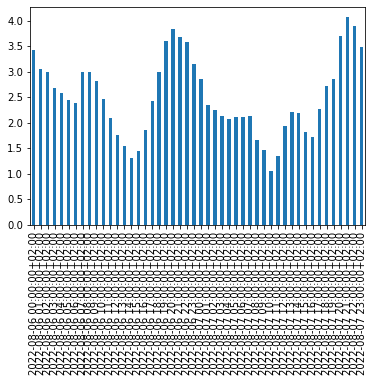

In [16]:
df_nok_kwh.plot.bar()

In [19]:
df_nok_kwh.reset_index().to_json(orient='records', date_format='iso')

,index,0
0,2022-08-06 00:00:00+02:00,3.428717
1,2022-08-06 01:00:00+02:00,3.047305
2,2022-08-06 02:00:00+02:00,2.984818
3,2022-08-06 03:00:00+02:00,2.673978
4,2022-08-06 04:00:00+02:00,2.589830
5,2022-08-06 05:00:00+02:00,2.435808
6,2022-08-06 06:00:00+02:00,2.381705
7,2022-08-06 07:00:00+02:00,2.994001
8,2022-08-06 08:00:00+02:00,2.994201
9,2022-08-06 09:00:00+02:00,2.816022
